In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [2]:
region = 'saag'
lon_box = [-82, -34]
lat_box = [-56, 13]
# lat_box = [-25, 13]

rootdir = '/global/cscratch1/sd/feng045/SAAG/GPM/'
# idlfile = f'{rootdir}stats_4pyflex/robust/filtered/robust_mcs_tracks_20190101_20190131.nc'
# pyfile = f'{rootdir}pyflex_test/stats/mcs_tracks_final_20190101.0000_20190131.2300.nc'
idlfile = f'{rootdir}stats_4pyflex/robust/filtered/robust_mcs_tracks_20180601_20190630.nc'
pyfile = f'{rootdir}pyflex_test2/stats/mcs_tracks_final_20180601.0000_20190630.2300.nc'

pixel_radius_idl = 10
pixel_radius_py = 10

figdir = f'/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/'
os.makedirs(figdir, exist_ok=True)

In [3]:
def find_track_in_region(times, lons, lats, lon_bounds, lat_bounds):
    
    # Get the track initiation month and location
#     start_month = times.isel(times=0).dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where((start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
                      (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)))[0]
    print('Number of MCS: ', len(mcsidx))
    return mcsidx

In [4]:
# Read IDL data
dsidl = xr.open_dataset(idlfile)
# dsidl

In [5]:
# Read Python data
dspy = xr.open_dataset(pyfile)
# dspy

In [6]:
# # Get track initial time valuees
# base_time_idl = dsidl.base_time.load()
# starttime_idl = base_time_idl.isel(times=0)
# landfrac_idl = dsidl.pf_landfrac.load()
# lat0_idl = dsidl.meanlat.isel(times=0)
# lon0_idl = dsidl.meanlon.isel(times=0)
# landfrac0_idl = landfrac_idl.isel(times=0)
# print(f'Number of MCS (IDL): {len(lat0_idl)}')

In [7]:
# # Get track initial time valuees
# base_time_py = dspy.base_time.load()
# starttime_py = base_time_py.isel(times=0)
# landfrac_py = dspy.pf_landfrac.load()
# lat0_py = dspy.meanlat.isel(times=0)
# lon0_py = dspy.meanlon.isel(times=0)
# landfrac0_py = landfrac_py.isel(times=0)
# print(f'Number of MCS (Python): {len(lat0_py)}')

In [8]:
mcsidx_idl = find_track_in_region(dsidl.base_time, dsidl.meanlon, dsidl.meanlat, lon_box, lat_box)
mcsidx_py = find_track_in_region(dspy.base_time, dspy.meanlon, dspy.meanlat, lon_box, lat_box)

Number of MCS:  4121
Number of MCS:  4935


In [9]:
stime_idl = dsidl.base_time.isel(times=0, tracks=mcsidx_idl)
syear_idl = stime_idl.dt.year
smonth_idl = stime_idl.dt.month
shour_idl = stime_idl.dt.hour

ccslifetime_idl = dsidl.length.isel(tracks=mcsidx_idl)
lifetime_idl = dsidl.pf_length.isel(tracks=mcsidx_idl)
ccsarea_idl = dsidl.ccs_area.isel(tracks=mcsidx_idl)
ccsdiam_idl = 2 * np.sqrt(ccsarea_idl / np.pi)
mintb_idl = dsidl.mintb.isel(tracks=mcsidx_idl)
mcsstatus_idl = dsidl.mcs_status.isel(tracks=mcsidx_idl)
pflon_idl = dsidl.pf_lon.isel(tracks=mcsidx_idl, nmaxpf=0)
pflat_idl = dsidl.pf_lat.isel(tracks=mcsidx_idl, nmaxpf=0)
pfarea_idl = dsidl.pf_area.isel(tracks=mcsidx_idl, nmaxpf=0)
pfdiam_idl = 2 * np.sqrt(pfarea_idl / np.pi)
maxpfdiam_idl = pfdiam_idl.max(dim='times')
startresult_idl = dsidl.starttrackresult.isel(tracks=mcsidx_idl)
endresult_idl = dsidl.endtrackresult.isel(tracks=mcsidx_idl)

pfrainrate_idl = dsidl.pf_rainrate.isel(tracks=mcsidx_idl, nmaxpf=0)
pfaccumrain_idl = dsidl.pf_accumrain.isel(tracks=mcsidx_idl).sum(dim='nmaxpf')
maxpfrainrate_idl = pfrainrate_idl.max(dim='times')
meanpfrainrate_idl = pfrainrate_idl.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_idl = (dsidl.pf_accumrain.sum(dim='nmaxpf') * pixel_radius_idl**2).isel(tracks=mcsidx_idl)
pfvolrainheavy_idl = (dsidl.pf_accumrainheavy.sum(dim='nmaxpf') * pixel_radius_idl**2).isel(tracks=mcsidx_idl)

speed_idl = dsidl.movement_r_meters_per_second.isel(tracks=mcsidx_idl)
movex_idl = dsidl.movement_storm_x.isel(tracks=mcsidx_idl)
movey_idl = dsidl.movement_storm_y.isel(tracks=mcsidx_idl)

landfrac_idl = dsidl.pf_landfrac.isel(tracks=mcsidx_idl)
init_landfrac_idl = landfrac_idl.isel(times=0)

# Use initiation location to define land vs. oean
mcsidx_land_idl = np.where(init_landfrac_idl > 0.8)[0]
mcsidx_ocean_idl = np.where(init_landfrac_idl < 0.2)[0]
# mcsidx_land_idl = np.where(init_landfrac_idl < 0.1)[0]
# mcsidx_ocean_idl = np.where(init_landfrac_idl > 0.8)[0]
nmcs_land_idl = len(mcsidx_land_idl)
nmcs_ocean_idl = len(mcsidx_ocean_idl)

print(f'Number of land MCS (IDL): {nmcs_land_idl}, Number of ocean MCS (IDL): {nmcs_ocean_idl}')

Number of land MCS (IDL): 2728, Number of ocean MCS (IDL): 817


In [10]:
print(list(dspy.keys()))

['track_duration', 'start_status', 'end_status', 'start_basetime', 'end_basetime', 'start_split_cloudnumber', 'end_merge_cloudnumber', 'base_time', 'meanlat', 'meanlon', 'area', 'cloudnumber', 'track_status', 'track_interruptions', 'core_area', 'cold_area', 'corecold_mintb', 'corecold_meantb', 'core_meantb', 'mcs_duration', 'mcs_status', 'ccs_area', 'merge_cloudnumber', 'split_cloudnumber', 'merge_ccs_area', 'split_ccs_area', 'pf_npf', 'pf_lon', 'pf_lat', 'pf_area', 'pf_rainrate', 'pf_skewness', 'pf_majoraxis', 'pf_minoraxis', 'pf_aspectratio', 'pf_orientation', 'pf_eccentricity', 'pf_lon_centroid', 'pf_lat_centroid', 'pf_lon_weightedcentroid', 'pf_lat_weightedcentroid', 'pf_maxrainrate', 'pf_accumrain', 'pf_accumrainheavy', 'pf_landfrac', 'total_rain', 'total_heavyrain', 'rainrate_heavyrain', 'pf_lifetime', 'pf_mcsstatus', 'movement_distance', 'movement_speed', 'movement_theta', 'movement_distance_x', 'movement_distance_y']


In [11]:
stime_py = dspy.base_time.isel(times=0, tracks=mcsidx_py)
syear_py = stime_py.dt.year
smonth_py = stime_py.dt.month
shour_py = stime_py.dt.hour

time_res = dspy.attrs['time_resolution_hour']
ccslifetime_py = dspy.track_duration.isel(tracks=mcsidx_py) * time_res
lifetime_py = dspy.pf_lifetime.isel(tracks=mcsidx_py)
ccsarea_py = dspy.ccs_area.isel(tracks=mcsidx_py)
ccsdiam_py = 2 * np.sqrt(ccsarea_py / np.pi)
mintb_py = dspy.corecold_mintb.isel(tracks=mcsidx_py)
mcsstatus_py = dspy.mcs_status.isel(tracks=mcsidx_py)
pflon_py = dspy.pf_lon.isel(tracks=mcsidx_py, nmaxpf=0)
pflat_py = dspy.pf_lat.isel(tracks=mcsidx_py, nmaxpf=0)
pfarea_py = dspy.pf_area.isel(tracks=mcsidx_py, nmaxpf=0)
pfdiam_py = 2 * np.sqrt(pfarea_py / np.pi)
maxpfdiam_py = pfdiam_py.max(dim='times')
startresult_py = dspy.start_status.isel(tracks=mcsidx_py)
endresult_py = dspy.end_status.isel(tracks=mcsidx_py)

pfrainrate_py = dspy.pf_rainrate.isel(tracks=mcsidx_py, nmaxpf=0)
pfaccumrain_py = dspy.pf_accumrain.isel(tracks=mcsidx_py).sum(dim='nmaxpf')
maxpfrainrate_py = pfrainrate_py.max(dim='times')
meanpfrainrate_py = pfrainrate_py.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_py = (dspy.pf_accumrain.sum(dim='nmaxpf') * pixel_radius_py**2).isel(tracks=mcsidx_py)
pfvolrainheavy_py = (dspy.pf_accumrainheavy.sum(dim='nmaxpf') * pixel_radius_py**2).isel(tracks=mcsidx_py)

speed_py = dspy.movement_speed.isel(tracks=mcsidx_py)
movex_py = dspy.movement_distance_x.isel(tracks=mcsidx_py)
movey_py = dspy.movement_distance_y.isel(tracks=mcsidx_py)

landfrac_py = dspy.pf_landfrac.isel(tracks=mcsidx_py)
init_landfrac_py = landfrac_py.isel(times=0)

# Use initiation location to define land vs. oean
mcsidx_land_py = np.where(init_landfrac_py > 0.8)[0]
mcsidx_ocean_py = np.where(init_landfrac_py < 0.2)[0]
nmcs_land_py = len(mcsidx_land_py)
nmcs_ocean_py = len(mcsidx_ocean_py)

print(f'Number of land MCS (Python): {nmcs_land_py}, Number of ocean MCS (Python): {nmcs_ocean_py}')

Number of land MCS (Python): 3355, Number of ocean MCS (Python): 915


In [12]:
bt_land_idl = dsidl.base_time.isel(tracks=mcsidx_land_idl)
stime_land_idl = stime_idl.isel(tracks=mcsidx_land_idl)
syear_land_idl = stime_land_idl.dt.year
smonth_land_idl = stime_land_idl.dt.month
shour_land_idl = stime_land_idl.dt.hour

pflandfrac_land_idl = landfrac_idl.isel(tracks=mcsidx_land_idl)
ccsarea_land_idl = ccsarea_idl.isel(tracks=mcsidx_land_idl)
ccsdiam_land_idl = ccsdiam_idl.isel(tracks=mcsidx_land_idl)
mintb_land_idl = mintb_idl.isel(tracks=mcsidx_land_idl)
mcsstatus_land_idl = mcsstatus_idl.isel(tracks=mcsidx_land_idl)
pflon_land_idl = pflon_idl.isel(tracks=mcsidx_land_idl)
pflat_land_idl = pflat_idl.isel(tracks=mcsidx_land_idl)
ccslifetime_land_idl = ccslifetime_idl.isel(tracks=mcsidx_land_idl)
lifetime_land_idl = lifetime_idl.isel(tracks=mcsidx_land_idl)
pfarea_land_idl = pfarea_idl.isel(tracks=mcsidx_land_idl)
pfdiam_land_idl = pfdiam_idl.isel(tracks=mcsidx_land_idl)
pfrainrate_land_idl = pfrainrate_idl.isel(tracks=mcsidx_land_idl)
pfaccumrain_land_idl = pfaccumrain_idl.isel(tracks=mcsidx_land_idl)
maxpfdiam_land_idl = maxpfdiam_idl.isel(tracks=mcsidx_land_idl)
maxpfrainrate_land_idl = maxpfrainrate_idl.isel(tracks=mcsidx_land_idl)
meanpfrainrate_land_idl = meanpfrainrate_idl.isel(tracks=mcsidx_land_idl)
startresult_land_idl = startresult_idl.isel(tracks=mcsidx_land_idl)
endresult_land_idl = endresult_idl.isel(tracks=mcsidx_land_idl)
pfvolrain_land_idl = pfvolrain_idl.isel(tracks=mcsidx_land_idl)
pfvolrainheavy_land_idl = pfvolrainheavy_idl.isel(tracks=mcsidx_land_idl)
speed_land_idl = speed_idl.isel(tracks=mcsidx_land_idl)
movex_land_idl = movex_idl.isel(tracks=mcsidx_land_idl)
movey_land_idl = movey_idl.isel(tracks=mcsidx_land_idl)

bt_ocean_idl = dsidl.base_time.isel(tracks=mcsidx_ocean_idl)
stime_ocean_idl = stime_idl.isel(tracks=mcsidx_ocean_idl)
syear_ocean_idl = stime_ocean_idl.dt.year
smonth_ocean_idl = stime_ocean_idl.dt.month
shour_ocean_idl = stime_ocean_idl.dt.hour

pflandfrac_ocean_idl = landfrac_idl.isel(tracks=mcsidx_ocean_idl)
ccsarea_ocean_idl = ccsarea_idl.isel(tracks=mcsidx_ocean_idl)
ccsdiam_ocean_idl = ccsdiam_idl.isel(tracks=mcsidx_ocean_idl)
mintb_ocean_idl = mintb_idl.isel(tracks=mcsidx_ocean_idl)
mcsstatus_ocean_idl = mcsstatus_idl.isel(tracks=mcsidx_ocean_idl)
pflon_ocean_idl = pflon_idl.isel(tracks=mcsidx_ocean_idl)
pflat_ocean_idl = pflat_idl.isel(tracks=mcsidx_ocean_idl)
ccslifetime_ocean_idl = ccslifetime_idl.isel(tracks=mcsidx_ocean_idl)
lifetime_ocean_idl = lifetime_idl.isel(tracks=mcsidx_ocean_idl)
pfarea_ocean_idl = pfarea_idl.isel(tracks=mcsidx_ocean_idl)
pfdiam_ocean_idl = pfdiam_idl.isel(tracks=mcsidx_ocean_idl)
pfrainrate_ocean_idl = pfrainrate_idl.isel(tracks=mcsidx_ocean_idl)
pfaccumrain_ocean_idl = pfaccumrain_idl.isel(tracks=mcsidx_ocean_idl)
maxpfdiam_ocean_idl = maxpfdiam_idl.isel(tracks=mcsidx_ocean_idl)
maxpfrainrate_ocean_idl = maxpfrainrate_idl.isel(tracks=mcsidx_ocean_idl)
meanpfrainrate_ocean_idl = meanpfrainrate_idl.isel(tracks=mcsidx_ocean_idl)
startresult_ocean_idl = startresult_idl.isel(tracks=mcsidx_ocean_idl)
endresult_ocean_idl = endresult_idl.isel(tracks=mcsidx_ocean_idl)
pfvolrain_ocean_idl = pfvolrain_idl.isel(tracks=mcsidx_ocean_idl)
pfvolrainheavy_ocean_idl = pfvolrainheavy_idl.isel(tracks=mcsidx_ocean_idl)
speed_ocean_idl = speed_idl.isel(tracks=mcsidx_ocean_idl)
movex_ocean_idl = movex_idl.isel(tracks=mcsidx_ocean_idl)
movey_ocean_idl = movey_idl.isel(tracks=mcsidx_ocean_idl)

In [13]:
bt_land_py = dspy.base_time.isel(tracks=mcsidx_land_py)
stime_land_py = stime_py.isel(tracks=mcsidx_land_py)
syear_land_py = stime_land_py.dt.year
smonth_land_py = stime_land_py.dt.month
shour_land_py = stime_land_py.dt.hour

pflandfrac_land_py = landfrac_py.isel(tracks=mcsidx_land_py)
ccsarea_land_py = ccsarea_py.isel(tracks=mcsidx_land_py)
ccsdiam_land_py = ccsdiam_py.isel(tracks=mcsidx_land_py)
mintb_land_py = mintb_py.isel(tracks=mcsidx_land_py)
mcsstatus_land_py = mcsstatus_py.isel(tracks=mcsidx_land_py)
pflon_land_py = pflon_py.isel(tracks=mcsidx_land_py)
pflat_land_py = pflat_py.isel(tracks=mcsidx_land_py)
ccslifetime_land_py = ccslifetime_py.isel(tracks=mcsidx_land_py)
lifetime_land_py = lifetime_py.isel(tracks=mcsidx_land_py)
pfarea_land_py = pfarea_py.isel(tracks=mcsidx_land_py)
pfdiam_land_py = pfdiam_py.isel(tracks=mcsidx_land_py)
pfrainrate_land_py = pfrainrate_py.isel(tracks=mcsidx_land_py)
pfaccumrain_land_py = pfaccumrain_py.isel(tracks=mcsidx_land_py)
maxpfdiam_land_py = maxpfdiam_py.isel(tracks=mcsidx_land_py)
maxpfrainrate_land_py = maxpfrainrate_py.isel(tracks=mcsidx_land_py)
meanpfrainrate_land_py = meanpfrainrate_py.isel(tracks=mcsidx_land_py)
startresult_land_py = startresult_py.isel(tracks=mcsidx_land_py)
endresult_land_py = endresult_py.isel(tracks=mcsidx_land_py)
pfvolrain_land_py = pfvolrain_py.isel(tracks=mcsidx_land_py)
pfvolrainheavy_land_py = pfvolrainheavy_py.isel(tracks=mcsidx_land_py)
speed_land_py = speed_py.isel(tracks=mcsidx_land_py)
movex_land_py = movex_py.isel(tracks=mcsidx_land_py)
movey_land_py = movey_py.isel(tracks=mcsidx_land_py)

bt_ocean_py = dspy.base_time.isel(tracks=mcsidx_ocean_py)
stime_ocean_py = stime_py.isel(tracks=mcsidx_ocean_py)
syear_ocean_py = stime_ocean_py.dt.year
smonth_ocean_py = stime_ocean_py.dt.month
shour_ocean_py = stime_ocean_py.dt.hour

pflandfrac_ocean_py = landfrac_py.isel(tracks=mcsidx_ocean_py)
ccsarea_ocean_py = ccsarea_py.isel(tracks=mcsidx_ocean_py)
ccsdiam_ocean_py = ccsdiam_py.isel(tracks=mcsidx_ocean_py)
mintb_ocean_py = mintb_py.isel(tracks=mcsidx_ocean_py)
mcsstatus_ocean_py = mcsstatus_py.isel(tracks=mcsidx_ocean_py)
pflon_ocean_py = pflon_py.isel(tracks=mcsidx_ocean_py)
pflat_ocean_py = pflat_py.isel(tracks=mcsidx_ocean_py)
ccslifetime_ocean_py = ccslifetime_py.isel(tracks=mcsidx_ocean_py)
lifetime_ocean_py = lifetime_py.isel(tracks=mcsidx_ocean_py)
pfarea_ocean_py = pfarea_py.isel(tracks=mcsidx_ocean_py)
pfdiam_ocean_py = pfdiam_py.isel(tracks=mcsidx_ocean_py)
pfrainrate_ocean_py = pfrainrate_py.isel(tracks=mcsidx_ocean_py)
pfaccumrain_ocean_py = pfaccumrain_py.isel(tracks=mcsidx_ocean_py)
maxpfdiam_ocean_py = maxpfdiam_py.isel(tracks=mcsidx_ocean_py)
maxpfrainrate_ocean_py = maxpfrainrate_py.isel(tracks=mcsidx_ocean_py)
meanpfrainrate_ocean_py = meanpfrainrate_py.isel(tracks=mcsidx_ocean_py)
startresult_ocean_py = startresult_py.isel(tracks=mcsidx_ocean_py)
endresult_ocean_py = endresult_py.isel(tracks=mcsidx_ocean_py)
pfvolrain_ocean_py = pfvolrain_py.isel(tracks=mcsidx_ocean_py)
pfvolrainheavy_ocean_py = pfvolrainheavy_py.isel(tracks=mcsidx_ocean_py)
speed_ocean_py = speed_py.isel(tracks=mcsidx_ocean_py)
movex_ocean_py = movex_py.isel(tracks=mcsidx_ocean_py)
movey_ocean_py = movey_py.isel(tracks=mcsidx_ocean_py)

In [14]:
# life_bins = np.arange(4, 60.1, 4)
life_bins = np.arange(0, 60.1, 4)
binrange = (0, 60)
pdf_lifetime_land_idl, bins = np.histogram(lifetime_land_idl, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_idl, bins = np.histogram(lifetime_ocean_idl, bins=life_bins, range=binrange, density=True)

pdf_lifetime_land_py, bins = np.histogram(lifetime_land_py, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_py, bins = np.histogram(lifetime_ocean_py, bins=life_bins, range=binrange, density=True)

(array([4.470e+03, 2.352e+03, 1.049e+03, 4.820e+02, 2.000e+02, 9.600e+01,
        5.100e+01, 2.500e+01, 4.000e+00, 9.000e+00]),
 array([ 225.95775,  364.7478 ,  503.53787,  642.32794,  781.118  ,
         919.9081 , 1058.6981 , 1197.4882 , 1336.2783 , 1475.0684 ,
        1613.8584 ], dtype=float32),
 <BarContainer object of 10 artists>)

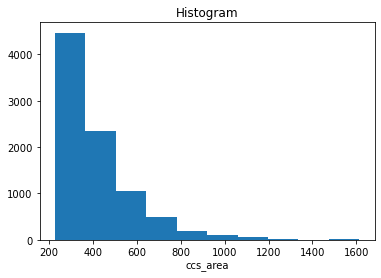

In [15]:
ccsdiam_ocean_idl.where(mcsstatus_ocean_idl == 1).plot.hist()

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


(array([0.000e+00, 0.000e+00, 0.000e+00, 4.780e+02, 1.380e+03, 4.227e+03,
        8.707e+03, 3.304e+03, 3.730e+02, 3.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

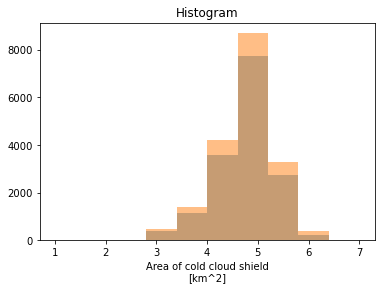

In [16]:
np.log10(ccsarea_ocean_idl).plot.hist(range=(1,7), alpha=0.5)
np.log10(ccsarea_ocean_py).plot.hist(range=(1,7), alpha=0.5)

In [17]:
speed_bins = np.arange(0,50.1,3)
binrange = (0, 50)
pdf_speed_land_idl, bins = np.histogram(speed_land_idl, bins=speed_bins, range=binrange, density=True)
pdf_speed_ocean_idl, bins = np.histogram(speed_ocean_idl, bins=speed_bins, range=binrange, density=True)

pdf_speed_land_py, bins = np.histogram(speed_land_py, bins=speed_bins, range=binrange, density=True)
pdf_speed_ocean_py, bins = np.histogram(speed_ocean_py, bins=speed_bins, range=binrange, density=True)

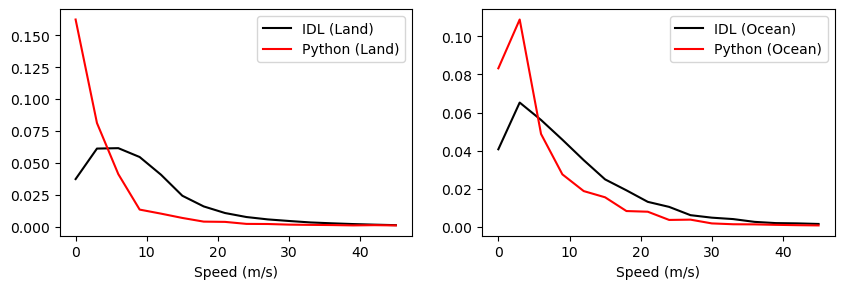

In [18]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(speed_bins[:-1], pdf_speed_land_idl, color='k', label='IDL (Land)')
ax.plot(speed_bins[:-1], pdf_speed_land_py, color='r', label='Python (Land)')
ax.set_xlabel('Speed (m/s)')
ax.legend()

ax = axs[1]
ax.plot(speed_bins[:-1], pdf_speed_ocean_idl, color='k', label='IDL (Ocean)')
ax.plot(speed_bins[:-1], pdf_speed_ocean_py, color='r', label='Python (Ocean)')
ax.set_xlabel('Speed (m/s)')
ax.legend()

In [19]:
# movex_land_idl.plot.hist()
# movey_land_idl.plot.hist()
movement_bins = np.arange(-50, 51, 5)
binrange = (-150, 150)
pdf_movex_land_idl, bins = np.histogram(movex_land_idl, bins=movement_bins, range=binrange, density=True)
pdf_movey_land_idl, bins = np.histogram(movey_land_idl, bins=movement_bins, range=binrange, density=True)

pdf_movex_land_py, bins = np.histogram(movex_land_py, bins=movement_bins, range=binrange, density=True)
pdf_movey_land_py, bins = np.histogram(movey_land_py, bins=movement_bins, range=binrange, density=True)

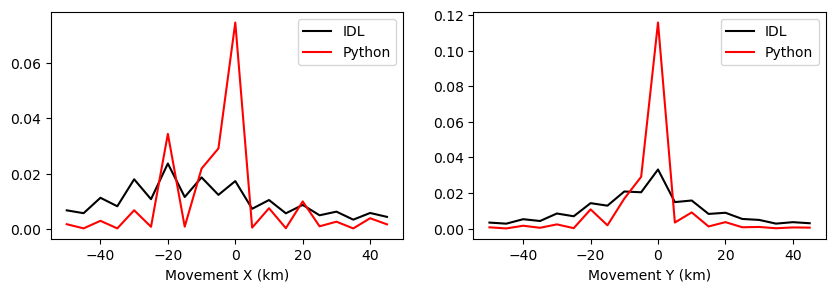

In [20]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(movement_bins[:-1], pdf_movex_land_idl, color='k', label='IDL')
ax.plot(movement_bins[:-1], pdf_movex_land_py, color='r', label='Python')
ax.set_xlabel('Movement X (km)')
ax.legend()

ax = axs[1]
ax.plot(movement_bins[:-1], pdf_movey_land_idl, color='k', label='IDL')
ax.plot(movement_bins[:-1], pdf_movey_land_py, color='r', label='Python')
ax.set_xlabel('Movement Y (km)')
ax.legend()

In [21]:
ccsarea_bins = np.arange(2, 7.01, 0.2)
binrange = (2, 7)
pdf_ccsarea_land_idl, bins = np.histogram(np.log10(ccsarea_land_idl), bins=ccsarea_bins, range=binrange, density=True)
pdf_ccsarea_ocean_idl, bins = np.histogram(np.log10(ccsarea_ocean_idl), bins=ccsarea_bins, range=binrange, density=True)

pdf_ccsarea_land_py, bins = np.histogram(np.log10(ccsarea_land_py), bins=ccsarea_bins, range=binrange, density=True)
pdf_ccsarea_ocean_py, bins = np.histogram(np.log10(ccsarea_ocean_py), bins=ccsarea_bins, range=binrange, density=True)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


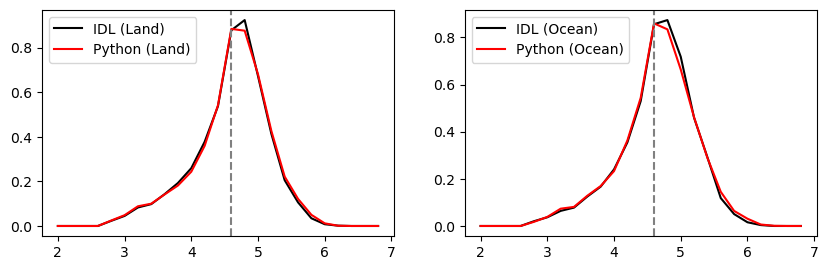

In [22]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_land_idl, color='k', label='IDL (Land)')
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_land_py, color='r', label='Python (Land)')
ax.axvline(np.log10(dsidl.attrs['MCS_area_km2']), color='gray', ls='--')
ax.legend()

ax = axs[1]
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_ocean_idl, color='k', label='IDL (Ocean)')
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_ocean_py, color='r', label='Python (Ocean)')
ax.axvline(np.log10(dsidl.attrs['MCS_area_km2']), color='gray', ls='--')
ax.legend()

In [23]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfdiam_bins = np.arange(0,600.1,25)
binrange = (0,600)
pdf_pfdiam_land_idl, bins = np.histogram(pfdiam_land_idl.where(mcsstatus_land_idl == 1), bins=pfdiam_bins, range=binrange, density=True)
pdf_pfdiam_ocean_idl, bins = np.histogram(pfdiam_ocean_idl.where(mcsstatus_ocean_idl == 1), bins=pfdiam_bins, range=binrange, density=True)

pdf_pfdiam_land_py, bins = np.histogram(pfdiam_land_py.where(mcsstatus_land_py == 1), bins=pfdiam_bins, range=binrange, density=True)
pdf_pfdiam_ocean_py, bins = np.histogram(pfdiam_ocean_py.where(mcsstatus_ocean_py == 1), bins=pfdiam_bins, range=binrange, density=True)

In [24]:
# Parameters are selected during MCS stage (mcsstatus==1)
rainrate_bins = np.arange(0,20.01,0.5)
binrange = (0,20)
pdf_pfrainrate_land_idl, bins = np.histogram(pfrainrate_land_idl.where(mcsstatus_land_idl == 1), bins=rainrate_bins, range=binrange, density=True)
pdf_pfrainrate_ocean_idl, bins = np.histogram(pfrainrate_ocean_idl.where(mcsstatus_ocean_idl == 1), bins=rainrate_bins, range=binrange, density=True)

pdf_pfrainrate_land_py, bins = np.histogram(pfrainrate_land_py.where(mcsstatus_land_py == 1), bins=rainrate_bins, range=binrange, density=True)
pdf_pfrainrate_ocean_py, bins = np.histogram(pfrainrate_ocean_py.where(mcsstatus_ocean_py == 1), bins=rainrate_bins, range=binrange, density=True)

In [25]:
# volrain_bins = np.arange(0,3.01,0.25)
volrain_bins = np.logspace(np.log10(0.02), np.log10(4.0), 25)
binrange = (0,4)
volrain_scale = 1e6

pdf_volrain_land_idl, bins = np.histogram(pfvolrain_land_idl.where(mcsstatus_land_idl == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrain_ocean_idl, bins = np.histogram(pfvolrain_ocean_idl.where(mcsstatus_ocean_idl == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

pdf_volrain_land_py, bins = np.histogram(pfvolrain_land_py.where(mcsstatus_land_py == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrain_ocean_py, bins = np.histogram(pfvolrain_ocean_py.where(mcsstatus_ocean_py == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

In [26]:
# Heavy rain volume
pdf_volrainheavy_land_idl, bins = np.histogram(pfvolrainheavy_land_idl.where(mcsstatus_land_idl == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrainheavy_ocean_idl, bins = np.histogram(pfvolrainheavy_ocean_idl.where(mcsstatus_ocean_idl == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

pdf_volrainheavy_land_py, bins = np.histogram(pfvolrainheavy_land_py.where(mcsstatus_land_py == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrainheavy_ocean_py, bins = np.histogram(pfvolrainheavy_ocean_py.where(mcsstatus_ocean_py == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

In [27]:
# Heavy rain volume ratio
pfhrr_land_idl = pfvolrainheavy_land_idl / pfvolrain_land_idl
pfhrr_ocean_idl = pfvolrainheavy_ocean_idl / pfvolrain_ocean_idl
pfhrr_land_py = pfvolrainheavy_land_py / pfvolrain_land_py
pfhrr_ocean_py = pfvolrainheavy_ocean_py / pfvolrain_ocean_py

hrr_bins = np.arange(0.05, 1.01, 0.05)
binrange = (0.05,1)
pdf_hrr_land_idl, bins = np.histogram(pfhrr_land_idl.where(mcsstatus_land_idl == 1), bins=hrr_bins, range=binrange, density=True)
pdf_hrr_ocean_idl, bins = np.histogram(pfhrr_ocean_idl.where(mcsstatus_ocean_idl == 1), bins=hrr_bins, range=binrange, density=True)

pdf_hrr_land_py, bins = np.histogram(pfhrr_land_py.where(mcsstatus_land_py == 1), bins=hrr_bins, range=binrange, density=True)
pdf_hrr_ocean_py, bins = np.histogram(pfhrr_ocean_py.where(mcsstatus_ocean_py == 1), bins=hrr_bins, range=binrange, density=True)

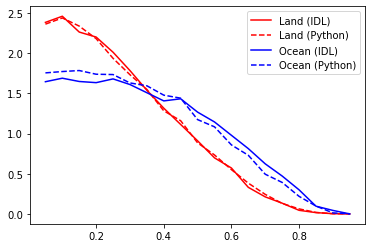

In [28]:
plt.plot(hrr_bins[:-1], pdf_hrr_land_idl, 'r', label='Land (IDL)')
plt.plot(hrr_bins[:-1], pdf_hrr_land_py, 'r--', label=f'Land (Python)')
# plt.plot(hrr_bins[:-1], pdf_hrr_land_m2, 'r:', label=f'Land ({e3sm_name[runname2]})')

plt.plot(hrr_bins[:-1], pdf_hrr_ocean_idl, 'b', label='Ocean (IDL)')
plt.plot(hrr_bins[:-1], pdf_hrr_ocean_py, 'b--', label=f'Ocean (Python)')
# plt.plot(hrr_bins[:-1], pdf_hrr_ocean_m2, 'b:', label=f'Ocean ({e3sm_name[runname2]})')
plt.legend()

In [29]:
def plot_pdf_8panels(bins, data_idl, data_py, ns_idl, ns_py,  
                     titles, xlabels, xticks, xscales, yscales, ylims, 
                     map_extent, lon_box, lat_box, inset_param, figname,
                     legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=[10,10], dpi=100)

    colors = {'IDL':'steelblue', 'm1':'darkorange'}

    for row in range(0,4):
        for col in range(0,2): 
            ax = axes[row][col]
            ax.plot(bins[row][0:-1], data_idl[row][col], colors['IDL'], lw=3, label=f'IDL ({ns_idl[row][col]})')
            ax.plot(bins[row][0:-1], data_py[row][col], colors['m1'], lw=3, label=f'Python ({ns_py[row][col]})')
#             ax.plot(bins[row][0:-1], data_m2[row][col], colors['m2'], lw=3, label=f'{e3sm_name[runname2]} ({ns_m2[row][col]})')
#             ax.plot(bins[row][0:-1], data_m3[row][col], colors['m3'], lw=3, label=f'{e3sm_name[runname3]} ({ns_m3[row][col]})')
#             ax.plot(bins[row][0:-1], data_m4[row][col], colors['m4'], lw=3, label=f'{e3sm_name[runname4]} ({ns_m4[row][col]})')
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel('Frequency')
            ax.set_xticks(xticks[row])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales[row])
            ax.set_yscale(yscales[row])
            if (row == 0):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)

                # Plot inset map
                if (row==0): 
                    resolution = '110m'
                    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                    proj = ccrs.PlateCarree(central_longitude=180)
                    box_proj = ccrs.PlateCarree(central_longitude=0)
                    sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                        axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                        axes_kwargs=dict(map_projection=proj))
                    sub_ax.set_extent(map_extent, crs=box_proj)
                    # Add land, coastlines, borders to inset
                    sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                    sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                    sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                    # Plot a box region in the inset
                    box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                    sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                    sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [30]:
lon_box

[-82, -34]

<ipython-input-29-935fe1e86678>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


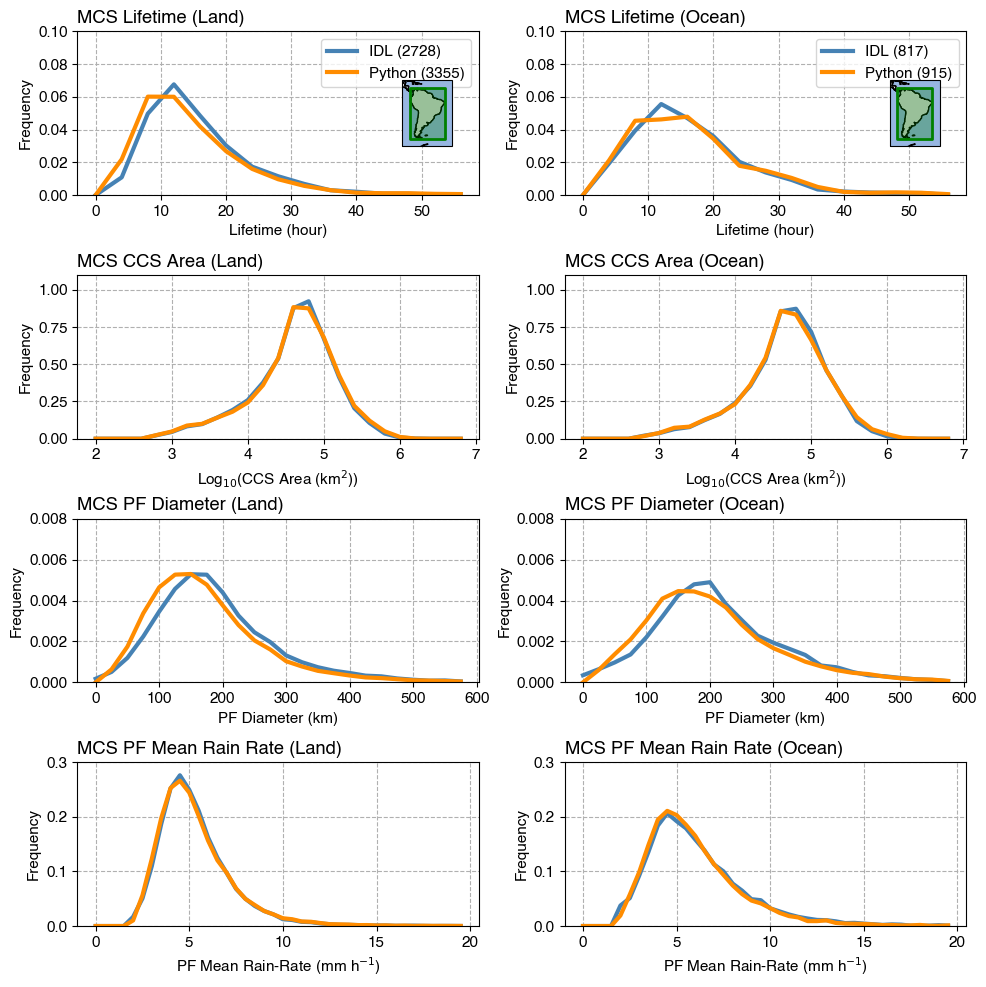

In [31]:
xbins = [life_bins, ccsarea_bins, pfdiam_bins, rainrate_bins]
data_idl = [[pdf_lifetime_land_idl, pdf_lifetime_ocean_idl],
            [pdf_ccsarea_land_idl, pdf_ccsarea_ocean_idl],
            [pdf_pfdiam_land_idl, pdf_pfdiam_ocean_idl],
            [pdf_pfrainrate_land_idl, pdf_pfrainrate_ocean_idl]]
data_py = [[pdf_lifetime_land_py, pdf_lifetime_ocean_py],
           [pdf_ccsarea_land_py, pdf_ccsarea_ocean_py],
           [pdf_pfdiam_land_py, pdf_pfdiam_ocean_py],
           [pdf_pfrainrate_land_py, pdf_pfrainrate_ocean_py]]
ns_idl = [[nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl]]
ns_py = [[nmcs_land_py, nmcs_ocean_py],
         [nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py]]
titles = [['MCS Lifetime (Land)', 'MCS Lifetime (Ocean)'],
          ['MCS CCS Area (Land)', 'MCS CCS Area (Ocean)'],
          ['MCS PF Diameter (Land)', 'MCS PF Diameter (Ocean)'],
          ['MCS PF Mean Rain Rate (Land)', 'MCS PF Mean Rain Rate (Ocean)']]
xlabels = ['Lifetime (hour)', 'Log$_{10}$(CCS Area (km$^2$))', 'PF Diameter (km)', 'PF Mean Rain-Rate (mm h$^{-1}$)' ]
# xticks = [np.arange(5, 60.01, 10), np.arange(0,801,100), np.arange(0,15.1,3), np.arange(0,4.1,0.5)]
xticks = [np.arange(5, 60.01, 10), np.arange(2, 7.01, 1), np.arange(0,601,100), np.arange(0,15.1,3),]
xscales = ['linear', 'linear', 'linear','linear']
yscales = ['linear', 'linear', 'linear','linear']
ylims = [[0,0.1],[0,1.1],[0,0.008],[0,0.3]]

bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'25%', 'height':'40%', 'loc':'center right', 'borderpad':0.1}

fig = plot_pdf_8panels(xbins, data_idl, data_py, ns_idl, ns_py,
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_lifetime_ccsarea_pfdiam_rainrate_landocean_{region}.png')

<ipython-input-29-935fe1e86678>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


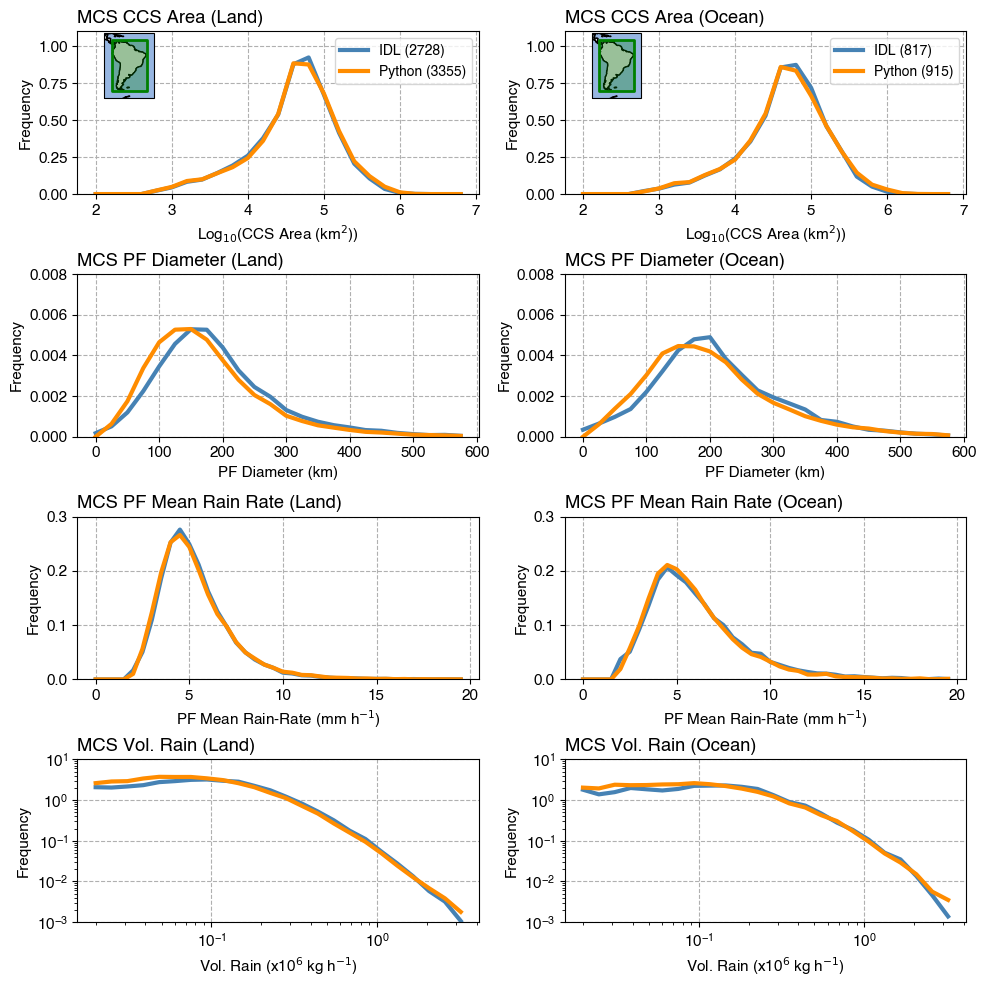

In [32]:
xbins = [ccsarea_bins, pfdiam_bins, rainrate_bins, volrain_bins]
data_idl = [[pdf_ccsarea_land_idl, pdf_ccsarea_ocean_idl],
            [pdf_pfdiam_land_idl, pdf_pfdiam_ocean_idl],
            [pdf_pfrainrate_land_idl, pdf_pfrainrate_ocean_idl], 
            [pdf_volrain_land_idl, pdf_volrain_ocean_idl]]
data_py = [[pdf_ccsarea_land_py, pdf_ccsarea_ocean_py],
           [pdf_pfdiam_land_py, pdf_pfdiam_ocean_py],
           [pdf_pfrainrate_land_py, pdf_pfrainrate_ocean_py],
           [pdf_volrain_land_py, pdf_volrain_ocean_py]]
ns_idl = [[nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl]]
ns_py = [[nmcs_land_py, nmcs_ocean_py],
         [nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py]]
titles = [['MCS CCS Area (Land)', 'MCS CCS Area (Ocean)'],
          ['MCS PF Diameter (Land)', 'MCS PF Diameter (Ocean)'],
          ['MCS PF Mean Rain Rate (Land)', 'MCS PF Mean Rain Rate (Ocean)'],
          ['MCS Vol. Rain (Land)', 'MCS Vol. Rain (Ocean)']]
xlabels = ['Log$_{10}$(CCS Area (km$^2$))', 'PF Diameter (km)', 'PF Mean Rain-Rate (mm h$^{-1}$)', 'Vol. Rain (x10$^{6}$ kg h$^{-1}$)', ]
xticks = [np.arange(2, 7.01, 1), np.arange(0,601,100), np.arange(0,15.1,3), np.arange(0,4.1,0.5)]
xscales = ['linear', 'linear','linear','log']
yscales = ['linear', 'linear','linear','log']
ylims = [[0,1.1],[0,0.008],[0,0.3],[1e-3,10]]

bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'25%', 'height':'40%', 'loc':'upper left', 'borderpad':0.1}
# bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
# map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
# inset_param = {'width':'45%', 'height':'30%', 'loc':'upper left', 'borderpad':0.2}

fig = plot_pdf_8panels(xbins, data_idl, data_py, ns_idl, ns_py,
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_ccsarea_pfdiam_rainrate_volrain_landocean_{region}.png', 
                       legend_loc='upper right', legend_fontsize=10)

In [33]:
def plot_pdf_6panels(bins, data_idl, data_py, ns_idl, ns_py,  
                     titles, xlabels, xticks, xscales, yscales, ylims, 
                     map_extent, lon_box, lat_box, inset_param, figname,
                     legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[10,8], dpi=100)

    colors = {'IDL':'steelblue', 'm1':'darkorange'}

    for row in range(0,3):
        for col in range(0,2): 
            ax = axes[row][col]
            ax.plot(bins[row][0:-1], data_idl[row][col], colors['IDL'], lw=3, label=f'IDL ({ns_idl[row][col]})')
            ax.plot(bins[row][0:-1], data_py[row][col], colors['m1'], lw=3, label=f'Python ({ns_py[row][col]})')
#             ax.plot(bins[row][0:-1], data_m2[row][col], colors['m2'], lw=3, label=f'{e3sm_name[runname2]} ({ns_m2[row][col]})')
#             ax.plot(bins[row][0:-1], data_m3[row][col], colors['m3'], lw=3, label=f'{e3sm_name[runname3]} ({ns_m3[row][col]})')
#             ax.plot(bins[row][0:-1], data_m4[row][col], colors['m4'], lw=3, label=f'{e3sm_name[runname4]} ({ns_m4[row][col]})')
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel('Frequency')
            ax.set_xticks(xticks[row])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales[row])
            ax.set_yscale(yscales[row])
            if (row == 0):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-33-ffc32709e0b9>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


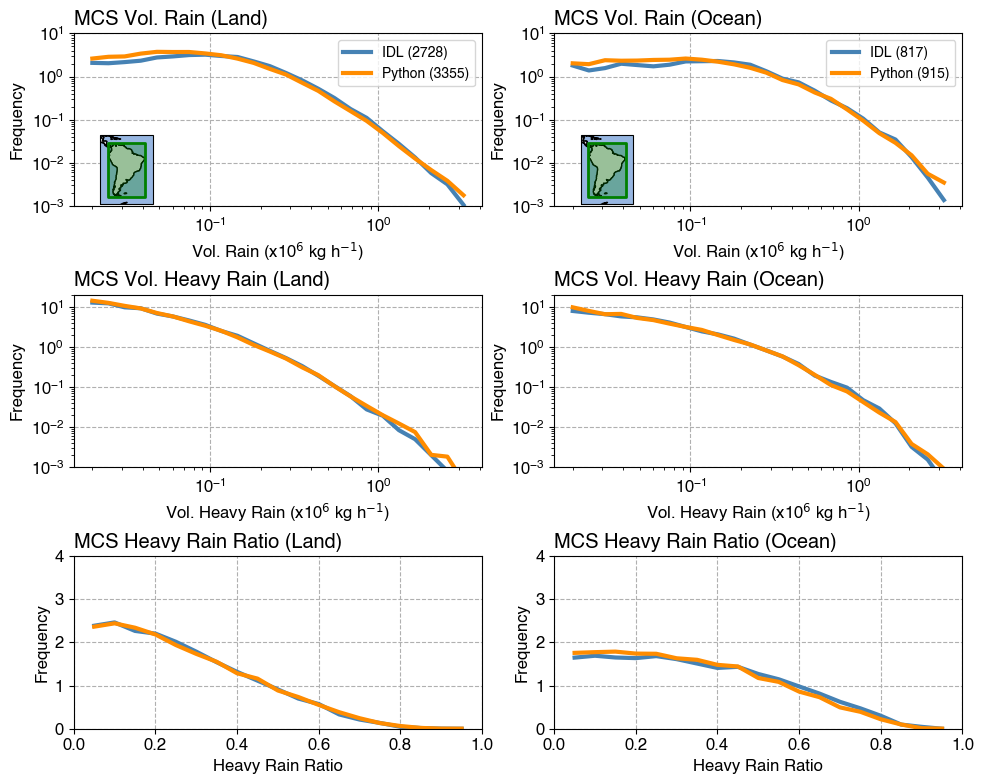

In [34]:
xbins = [volrain_bins, volrain_bins, hrr_bins]
data_idl = [[pdf_volrain_land_idl, pdf_volrain_ocean_idl],
            [pdf_volrainheavy_land_idl, pdf_volrainheavy_ocean_idl],
            [pdf_hrr_land_idl, pdf_hrr_ocean_idl]]
data_py = [[pdf_volrain_land_py, pdf_volrain_ocean_py],
            [pdf_volrainheavy_land_py, pdf_volrainheavy_ocean_py],
            [pdf_hrr_land_py, pdf_hrr_ocean_py]]
ns_idl = [[nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl],
          [nmcs_land_idl, nmcs_ocean_idl]]
ns_py = [[nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py],
          [nmcs_land_py, nmcs_ocean_py]]
xscales = ['log','log','linear']
yscales = ['log','log','linear']
titles = [['MCS Vol. Rain (Land)', 'MCS Vol. Rain (Ocean)'],
          ['MCS Vol. Heavy Rain (Land)', 'MCS Vol. Heavy Rain (Ocean)'],
          ['MCS Heavy Rain Ratio (Land)', 'MCS Heavy Rain Ratio (Ocean)']]
xlabels = ['Vol. Rain (x10$^{6}$ kg h$^{-1}$)', 'Vol. Heavy Rain (x10$^{6}$ kg h$^{-1}$)', 'Heavy Rain Ratio']
xticks = [np.arange(0,4.1,0.5), np.arange(0,4.1,0.5), np.arange(0,1.01,0.2)]
ylims = [[1e-3,10],[1e-3,20],[0,4.0]]

bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'25%', 'height':'40%', 'loc':'lower left', 'borderpad':0.1}
# bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
# map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
# inset_param = {'width':'50%', 'height':'30%', 'loc':'lower left', 'borderpad':0.2}

fig = plot_pdf_6panels(xbins, data_idl, data_py, ns_idl, ns_py, 
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_volrain_volheavyrain_hrr_landocean_{region}.png',
                       legend_loc='upper right', legend_fontsize=10)

(array([  1.,   0.,   0., 233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        393.,   0., 190.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <BarContainer object of 14 artists>)

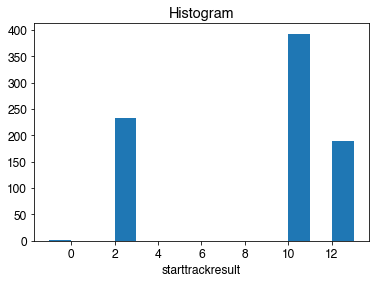

In [35]:
startresult_ocean_idl.plot.hist(bins=np.arange(-1,14,1))

(array([0.000e+00, 0.000e+00, 1.000e+00, 8.250e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.478e+03,
        0.000e+00, 4.240e+02]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <BarContainer object of 14 artists>)

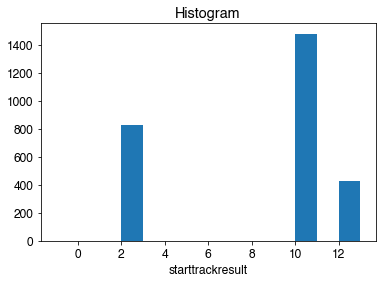

In [36]:
startresult_land_idl.plot.hist(bins=np.arange(-1,14,1))

(array([   0.,    0., 1730.,  611.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   15.,    0.,   16.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  534.,  260.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         127.,    0.,   62.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 <BarContainer object of 66 artists>)

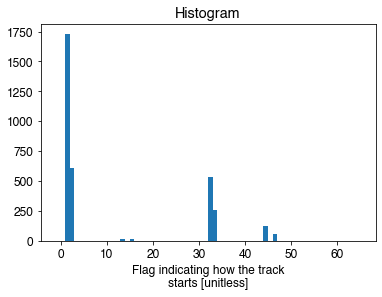

In [37]:
startresult_land_py.plot.hist(bins=np.arange(-1,66,1))

In [38]:
lifetime_land_idl.shape, startresult_land_idl.shape

((2728,), (2728,))

In [39]:
np.count_nonzero(startresult_land_py == 13)

15

In [40]:
figdir

'/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/'

In [41]:
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, startstatus, quantiles):
    in_var_cond = in_var.where((x_cond_var > x_cond_range[0]) & (x_cond_var <= x_cond_range[1]) & (startstatus == 10), drop=True)
    nsamples = in_var_cond.sizes['tracks']
    out_var_mean = in_var_cond.mean(dim='tracks')
    out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

In [42]:
def get_comp_tracks_by1cond_py(in_var, x_cond_var, x_cond_range, startstatus, quantiles):
    in_var_cond = in_var.where((x_cond_var > x_cond_range[0]) & (x_cond_var <= x_cond_range[1]) & (startstatus <= 2), drop=True)
    nsamples = in_var_cond.sizes['tracks']
    out_var_mean = in_var_cond.mean(dim='tracks')
    out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

In [43]:
quantiles = [0.25, 0.5, 0.75]
lifetime_range1 = [8, 10]
lifetime_range2 = [12, 16]
avg1_ccsarea_land_idl, qntl1_ccsarea_land_idl, ns1_land_idl = get_comp_tracks_by1cond(ccsarea_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_ccsarea_land_idl, qntl2_ccsarea_land_idl, ns2_land_idl = get_comp_tracks_by1cond(ccsarea_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_ccsarea_ocean_idl, qntl1_ccsarea_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(ccsarea_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_ccsarea_ocean_idl, qntl2_ccsarea_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(ccsarea_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_ccsarea_land_py, qntl1_ccsarea_land_py, ns1_land_idl = get_comp_tracks_by1cond_py(ccsarea_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_ccsarea_land_py, qntl2_ccsarea_land_py, ns2_land_idl = get_comp_tracks_by1cond_py(ccsarea_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_ccsarea_ocean_py, qntl1_ccsarea_ocean_py, ns1_ocean_idl = get_comp_tracks_by1cond_py(ccsarea_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_ccsarea_ocean_py, qntl2_ccsarea_ocean_py, ns2_ocean_idl = get_comp_tracks_by1cond_py(ccsarea_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [44]:
avg1_mintb_land_idl, qntl1_mintb_land_idl, ns1_land_idl = get_comp_tracks_by1cond(mintb_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_mintb_land_idl, qntl2_mintb_land_idl, ns2_land_idl = get_comp_tracks_by1cond(mintb_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_mintb_ocean_idl, qntl1_mintb_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(mintb_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_mintb_ocean_idl, qntl2_mintb_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(mintb_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_mintb_land_py, qntl1_mintb_land_py, ns1_land_py = get_comp_tracks_by1cond_py(mintb_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_mintb_land_py, qntl2_mintb_land_py, ns2_land_py = get_comp_tracks_by1cond_py(mintb_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_mintb_ocean_py, qntl1_mintb_ocean_py, ns1_ocean_py = get_comp_tracks_by1cond_py(mintb_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_mintb_ocean_py, qntl2_mintb_ocean_py, ns2_ocean_py = get_comp_tracks_by1cond_py(mintb_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [45]:
avg1_pfdiam_land_idl, qntl1_pfdiam_land_idl, ns1_land_idl = get_comp_tracks_by1cond(pfdiam_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_pfdiam_land_idl, qntl2_pfdiam_land_idl, ns2_land_idl = get_comp_tracks_by1cond(pfdiam_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_pfdiam_ocean_idl, qntl1_pfdiam_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(pfdiam_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_pfdiam_ocean_idl, qntl2_pfdiam_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(pfdiam_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_pfdiam_land_py, qntl1_pfdiam_land_py, ns1_land_idl = get_comp_tracks_by1cond_py(pfdiam_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_pfdiam_land_py, qntl2_pfdiam_land_py, ns2_land_idl = get_comp_tracks_by1cond_py(pfdiam_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_pfdiam_ocean_py, qntl1_pfdiam_ocean_py, ns1_ocean_idl = get_comp_tracks_by1cond_py(pfdiam_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_pfdiam_ocean_py, qntl2_pfdiam_ocean_py, ns2_ocean_idl = get_comp_tracks_by1cond_py(pfdiam_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [46]:
avg1_pfrainrate_land_idl, qntl1_pfrainrate_land_idl, ns1_land_idl = get_comp_tracks_by1cond(pfrainrate_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_pfrainrate_land_idl, qntl2_pfrainrate_land_idl, ns2_land_idl = get_comp_tracks_by1cond(pfrainrate_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_pfrainrate_ocean_idl, qntl1_pfrainrate_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(pfrainrate_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_pfrainrate_ocean_idl, qntl2_pfrainrate_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(pfrainrate_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_pfrainrate_land_py, qntl1_pfrainrate_land_py, ns1_land_idl = get_comp_tracks_by1cond_py(pfrainrate_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_pfrainrate_land_py, qntl2_pfrainrate_land_py, ns2_land_idl = get_comp_tracks_by1cond_py(pfrainrate_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_pfrainrate_ocean_py, qntl1_pfrainrate_ocean_py, ns1_ocean_idl = get_comp_tracks_by1cond_py(pfrainrate_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_pfrainrate_ocean_py, qntl2_pfrainrate_ocean_py, ns2_ocean_idl = get_comp_tracks_by1cond_py(pfrainrate_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [47]:
avg1_pfvolrain_land_idl, qntl1_pfvolrain_land_idl, ns1_land_idl = get_comp_tracks_by1cond(pfvolrain_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_pfvolrain_land_idl, qntl2_pfvolrain_land_idl, ns2_land_idl = get_comp_tracks_by1cond(pfvolrain_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_pfvolrain_ocean_idl, qntl1_pfvolrain_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(pfvolrain_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_pfvolrain_ocean_idl, qntl2_pfvolrain_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(pfvolrain_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_pfvolrain_land_py, qntl1_pfvolrain_land_py, ns1_land_idl = get_comp_tracks_by1cond_py(pfvolrain_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_pfvolrain_land_py, qntl2_pfvolrain_land_py, ns2_land_idl = get_comp_tracks_by1cond_py(pfvolrain_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_pfvolrain_ocean_py, qntl1_pfvolrain_ocean_py, ns1_ocean_idl = get_comp_tracks_by1cond_py(pfvolrain_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_pfvolrain_ocean_py, qntl2_pfvolrain_ocean_py, ns2_ocean_idl = get_comp_tracks_by1cond_py(pfvolrain_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

In [48]:
avg1_pfvolrainheavy_land_idl, qntl1_pfvolrainheavy_land_idl, ns1_land_idl = get_comp_tracks_by1cond(pfvolrainheavy_land_idl, lifetime_land_idl, lifetime_range1, startresult_land_idl, quantiles)
avg2_pfvolrainheavy_land_idl, qntl2_pfvolrainheavy_land_idl, ns2_land_idl = get_comp_tracks_by1cond(pfvolrainheavy_land_idl, lifetime_land_idl, lifetime_range2, startresult_land_idl, quantiles)
# avg1_pfvolrainheavy_ocean_idl, qntl1_pfvolrainheavy_ocean_idl, ns1_ocean_idl = get_comp_tracks_by1cond(pfvolrainheavy_ocean_idl, lifetime_ocean_idl, lifetime_range1, startresult_ocean_idl, quantiles)
# avg2_pfvolrainheavy_ocean_idl, qntl2_pfvolrainheavy_ocean_idl, ns2_ocean_idl = get_comp_tracks_by1cond(pfvolrainheavy_ocean_idl, lifetime_ocean_idl, lifetime_range2, startresult_ocean_idl, quantiles)

avg1_pfvolrainheavy_land_py, qntl1_pfvolrainheavy_land_py, ns1_land_idl = get_comp_tracks_by1cond_py(pfvolrainheavy_land_py, lifetime_land_py, lifetime_range1, startresult_land_py, quantiles)
avg2_pfvolrainheavy_land_py, qntl2_pfvolrainheavy_land_py, ns2_land_idl = get_comp_tracks_by1cond_py(pfvolrainheavy_land_py, lifetime_land_py, lifetime_range2, startresult_land_py, quantiles)
# avg1_pfvolrainheavy_ocean_py, qntl1_pfvolrainheavy_ocean_py, ns1_ocean_idl = get_comp_tracks_by1cond_py(pfvolrainheavy_ocean_py, lifetime_ocean_py, lifetime_range1, startresult_ocean_py, quantiles)
# avg2_pfvolrainheavy_ocean_py, qntl2_pfvolrainheavy_ocean_py, ns2_ocean_idl = get_comp_tracks_by1cond_py(pfvolrainheavy_ocean_py, lifetime_ocean_py, lifetime_range2, startresult_ocean_py, quantiles)

In [49]:
def plot_evolution_10panels(hours, dataavg_idl, dataqntl_idl, dataavg_py, dataqntl_py, ns_idl, ns_py,  
                            titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                            map_extent, lon_box, lat_box, inset_param, figname,
                            legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=[10,12], dpi=100)

    colors = {'IDL':'steelblue', 'm1':'darkorange'}

    for row in range(0,5):
        for col in range(0,2): 
            ax = axes[row][col]           
            ax.plot(hours[col], dataavg_idl[row][col], colors['IDL'], lw=3, label=legends['IDL'])
            ax.plot(hours[col], dataavg_py[row][col], colors['m1'], lw=3, label=legends['m1'])
            ax.fill_between(hours[col], dataqntl_idl[row][col][0], dataqntl_idl[row][col][1], facecolor=colors['IDL'],  alpha=0.3)
            ax.fill_between(hours[col], dataqntl_py[row][col][0], dataqntl_py[row][col][1], facecolor=colors['m1'],  alpha=0.3)

            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [50]:
# hours = [avg1_ccsarea_ocean_idl.times, avg2_ccsarea_ocean_idl.times]
# dataavg_idl = [[avg1_ccsarea_ocean_idl/1e4, avg2_ccsarea_ocean_idl/1e4],
#             [avg1_mintb_ocean_idl, avg2_mintb_ocean_idl],
#             [avg1_pfdiam_ocean_idl, avg2_pfdiam_ocean_idl], 
#             [avg1_pfrainrate_ocean_idl, avg2_pfrainrate_ocean_idl],
#             [avg1_pfvolrain_ocean_idl/1e5, avg2_pfvolrain_ocean_idl/1e5]]
# dataavg_py = [[avg1_ccsarea_ocean_py/1e4, avg2_ccsarea_ocean_py/1e4],
#             [avg1_mintb_ocean_py, avg2_mintb_ocean_py],
#             [avg1_pfdiam_ocean_py, avg2_pfdiam_ocean_py], 
#             [avg1_pfrainrate_ocean_py, avg2_pfrainrate_ocean_py],
#             [avg1_pfvolrain_ocean_py/1e5, avg2_pfvolrain_ocean_py/1e5]]
# dataqntl_idl = [[(qntl1_ccsarea_ocean_idl.sel(quantile=0.25)/1e4,qntl1_ccsarea_ocean_idl.sel(quantile=0.75)/1e4), 
#                  (qntl2_ccsarea_ocean_idl.sel(quantile=0.25)/1e4,qntl2_ccsarea_ocean_idl.sel(quantile=0.75)/1e4)],
#                 [(qntl1_mintb_ocean_idl.sel(quantile=0.25),qntl1_mintb_ocean_idl.sel(quantile=0.75)), 
#                  (qntl2_mintb_ocean_idl.sel(quantile=0.25),qntl2_mintb_ocean_idl.sel(quantile=0.75))],
#                 [(qntl1_pfdiam_ocean_idl.sel(quantile=0.25),qntl1_pfdiam_ocean_idl.sel(quantile=0.75)), 
#                  (qntl2_pfdiam_ocean_idl.sel(quantile=0.25),qntl2_pfdiam_ocean_idl.sel(quantile=0.75))],
#                 [(qntl1_pfrainrate_ocean_idl.sel(quantile=0.25),qntl1_pfrainrate_ocean_idl.sel(quantile=0.75)), 
#                  (qntl2_pfrainrate_ocean_idl.sel(quantile=0.25),qntl2_pfrainrate_ocean_idl.sel(quantile=0.75))],
#                 [(qntl1_pfvolrain_ocean_idl.sel(quantile=0.25)/1e5,qntl1_pfvolrain_ocean_idl.sel(quantile=0.75)/1e5), 
#                  (qntl2_pfvolrain_ocean_idl.sel(quantile=0.25)/1e5,qntl2_pfvolrain_ocean_idl.sel(quantile=0.75)/1e5)],]
# dataqntl_py = [[(qntl1_ccsarea_ocean_py.sel(quantile=0.25)/1e4,qntl1_ccsarea_ocean_py.sel(quantile=0.75)/1e4), 
#                  (qntl2_ccsarea_ocean_py.sel(quantile=0.25)/1e4,qntl2_ccsarea_ocean_py.sel(quantile=0.75)/1e4)],
#                 [(qntl1_mintb_ocean_py.sel(quantile=0.25),qntl1_mintb_ocean_py.sel(quantile=0.75)), 
#                  (qntl2_mintb_ocean_py.sel(quantile=0.25),qntl2_mintb_ocean_py.sel(quantile=0.75))],
#                 [(qntl1_pfdiam_ocean_py.sel(quantile=0.25),qntl1_pfdiam_ocean_py.sel(quantile=0.75)), 
#                  (qntl2_pfdiam_ocean_py.sel(quantile=0.25),qntl2_pfdiam_ocean_py.sel(quantile=0.75))],
#                 [(qntl1_pfrainrate_ocean_py.sel(quantile=0.25),qntl1_pfrainrate_ocean_py.sel(quantile=0.75)), 
#                  (qntl2_pfrainrate_ocean_py.sel(quantile=0.25),qntl2_pfrainrate_ocean_py.sel(quantile=0.75))],
#                 [(qntl1_pfvolrain_ocean_py.sel(quantile=0.25)/1e5,qntl1_pfvolrain_ocean_py.sel(quantile=0.75)/1e5), 
#                  (qntl2_pfvolrain_ocean_py.sel(quantile=0.25)/1e5,qntl2_pfvolrain_ocean_py.sel(quantile=0.75)/1e5)],]
# ns_idl = [ns1_ocean_idl, ns2_ocean_idl]
# ns_py = [ns1_ocean_py, ns2_ocean_py]
# titles = []
# titles = [[f'MCS CCS Area (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS CCS Area (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
#           [f'MCS Min T$_b$ (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Min T$_b$ (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
#           [f'MCS PF Diameter (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Diameter (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
#           [f'MCS PF Mean Rain Rate (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Mean Rain Rate (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
#           [f'MCS Vol. Rain (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Vol. Rain (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)']]
# xlabels = ['','','','','Hours since initiation']
# ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
# xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
# xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
# ylims = [(0,30), (200,240), (0,500), (2,14), (0,12)]
# legends = {'IDL':'IDL', 'm1':'Python'}
# figname = f'{figdir}mcs_composite_evolution_{region}_ocean.png'

# bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
# map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
# inset_param = {'width':'25%', 'height':'40%', 'loc':'upper left', 'borderpad':0.1}
# # bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
# # map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
# # inset_param = {'width':'40%', 'height':'30%', 'loc':'upper left', 'borderpad':0.2}

# fig = plot_evolution_10panels(hours, dataavg_idl, dataqntl_idl, dataavg_py, dataqntl_py, ns_idl, ns_py,  
#                               titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
#                               map_extent, lon_box, lat_box, inset_param, figname, legend_loc='upper right')

<ipython-input-49-52028dd3a3d2>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


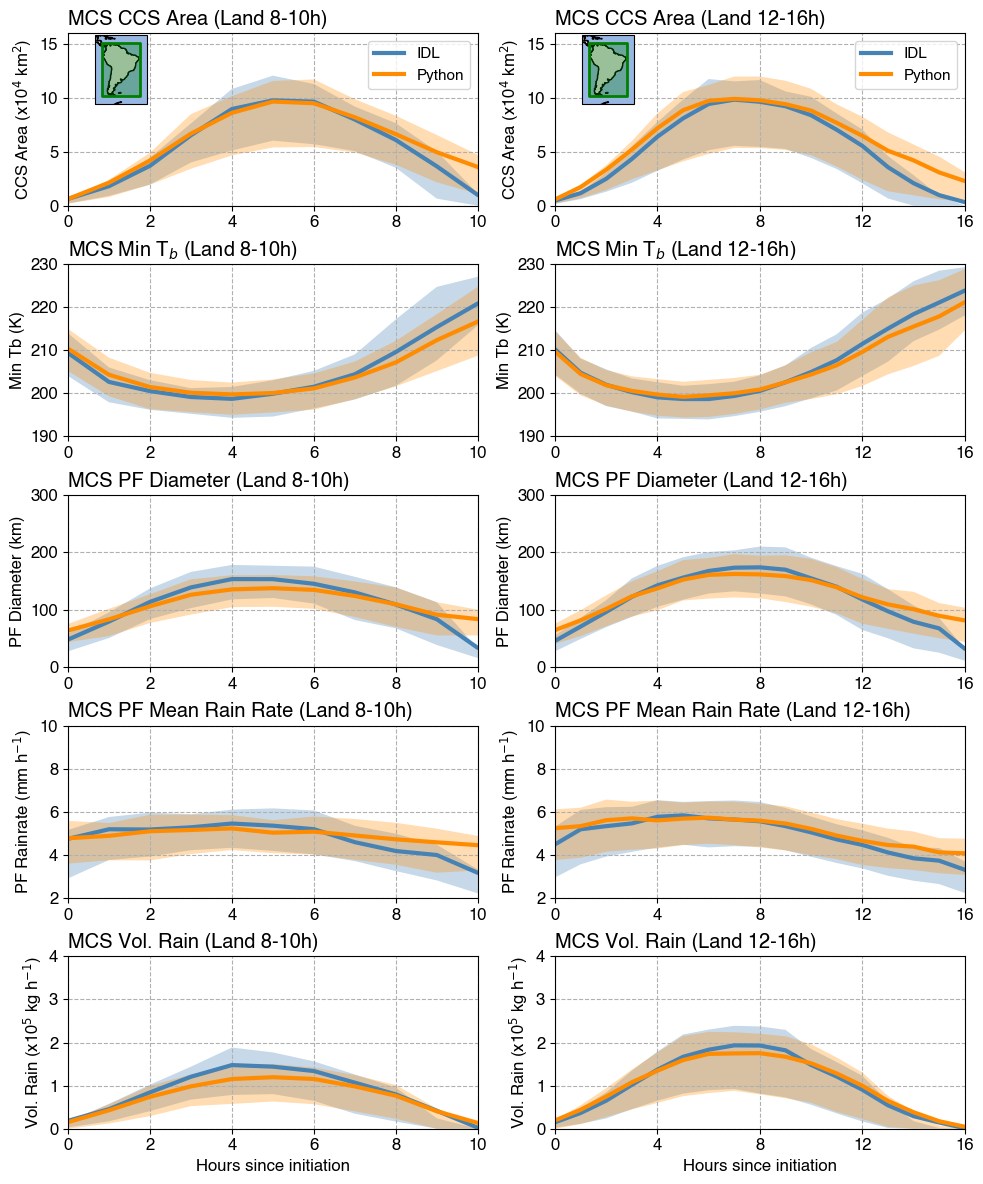

In [51]:
hours = [avg1_ccsarea_land_idl.times, avg2_ccsarea_land_idl.times]
dataavg_idl = [[avg1_ccsarea_land_idl/1e4, avg2_ccsarea_land_idl/1e4],
            [avg1_mintb_land_idl, avg2_mintb_land_idl],
            [avg1_pfdiam_land_idl, avg2_pfdiam_land_idl], 
            [avg1_pfrainrate_land_idl, avg2_pfrainrate_land_idl],
            [avg1_pfvolrain_land_idl/1e5, avg2_pfvolrain_land_idl/1e5]]
dataavg_py = [[avg1_ccsarea_land_py/1e4, avg2_ccsarea_land_py/1e4],
            [avg1_mintb_land_py, avg2_mintb_land_py],
            [avg1_pfdiam_land_py, avg2_pfdiam_land_py], 
            [avg1_pfrainrate_land_py, avg2_pfrainrate_land_py],
            [avg1_pfvolrain_land_py/1e5, avg2_pfvolrain_land_py/1e5]]
dataqntl_idl = [[(qntl1_ccsarea_land_idl.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_idl.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_idl.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_idl.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_idl.sel(quantile=0.25),qntl1_mintb_land_idl.sel(quantile=0.75)), 
                 (qntl2_mintb_land_idl.sel(quantile=0.25),qntl2_mintb_land_idl.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_idl.sel(quantile=0.25),qntl1_pfdiam_land_idl.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_idl.sel(quantile=0.25),qntl2_pfdiam_land_idl.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_idl.sel(quantile=0.25),qntl1_pfrainrate_land_idl.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_idl.sel(quantile=0.25),qntl2_pfrainrate_land_idl.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_idl.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_idl.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_idl.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_idl.sel(quantile=0.75)/1e5)],]
dataqntl_py = [[(qntl1_ccsarea_land_py.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_py.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_py.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_py.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_py.sel(quantile=0.25),qntl1_mintb_land_py.sel(quantile=0.75)), 
                 (qntl2_mintb_land_py.sel(quantile=0.25),qntl2_mintb_land_py.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_py.sel(quantile=0.25),qntl1_pfdiam_land_py.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_py.sel(quantile=0.25),qntl2_pfdiam_land_py.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_py.sel(quantile=0.25),qntl1_pfrainrate_land_py.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_py.sel(quantile=0.25),qntl2_pfrainrate_land_py.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_py.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_py.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_py.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_py.sel(quantile=0.75)/1e5)],]
ns_idl = [ns1_land_idl, ns2_land_idl]
ns_py = [ns1_land_py, ns2_land_py]
titles = []
titles = [[f'MCS CCS Area (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS CCS Area (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Min T$_b$ (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Min T$_b$ (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Diameter (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Diameter (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Mean Rain Rate (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Mean Rain Rate (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Vol. Rain (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Vol. Rain (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,16), (190,230), (0,300), (2,10), (0,4)]
legends = {'IDL':'IDL', 'm1':'Python'}
figname = f'{figdir}mcs_composite_evolution_{region}_land.png'

bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'25%', 'height':'40%', 'loc':'upper left', 'borderpad':0.1}
fig = plot_evolution_10panels(hours, dataavg_idl, dataqntl_idl, dataavg_py, dataqntl_py, ns_idl, ns_py,  
                              titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                              map_extent, lon_box, lat_box, inset_param, figname, legend_loc='upper right')

In [52]:
figdir

'/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/'

(0.0, 200000.0)

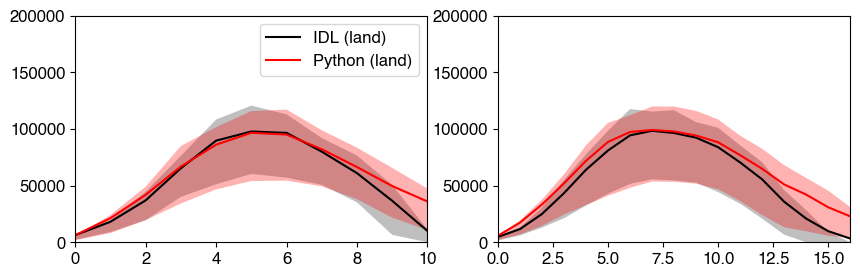

In [53]:
hours = avg1_ccsarea_land_idl.times
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(hours, avg1_ccsarea_land_idl, 'k', label='IDL (land)')
ax.plot(hours, avg1_ccsarea_land_py, 'r', label='Python (land)')
ax.fill_between(hours, qntl1_ccsarea_land_idl.sel(quantile=0.25), qntl1_ccsarea_land_idl.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours, qntl1_ccsarea_land_py.sel(quantile=0.25), qntl1_ccsarea_land_py.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range1))
ax.set_ylim(0,200000)
ax.legend()

ax = axs[1]
ax.plot(hours, avg2_ccsarea_land_idl, 'k', label='IDL (land)')
ax.plot(hours, avg2_ccsarea_land_py, 'r', label='Python (land)')
ax.fill_between(hours, qntl2_ccsarea_land_idl.sel(quantile=0.25), qntl2_ccsarea_land_idl.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours, qntl2_ccsarea_land_py.sel(quantile=0.25), qntl2_ccsarea_land_py.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range2))
ax.set_ylim(0,200000)

(190.0, 230.0)

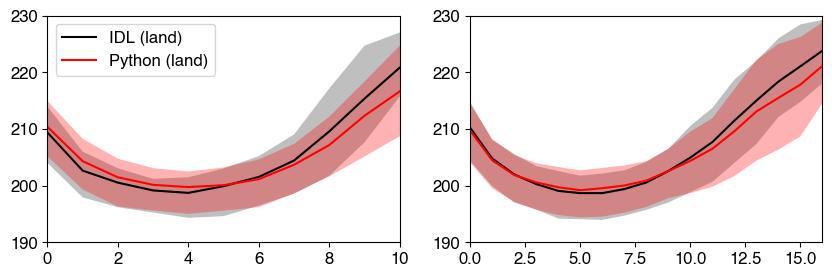

In [54]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(hours, avg1_mintb_land_idl, 'k', label='IDL (land)')
ax.plot(hours, avg1_mintb_land_py, 'r', label='Python (land)')
ax.fill_between(hours, qntl1_mintb_land_idl.sel(quantile=0.25), qntl1_mintb_land_idl.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours, qntl1_mintb_land_py.sel(quantile=0.25), qntl1_mintb_land_py.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range1))
ax.set_ylim(190,230)
ax.legend()

ax = axs[1]
ax.plot(hours, avg2_mintb_land_idl, 'k', label='IDL (land)')
ax.plot(hours, avg2_mintb_land_py, 'r', label='Python (land)')
ax.fill_between(hours, qntl2_mintb_land_idl.sel(quantile=0.25), qntl2_mintb_land_idl.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours, qntl2_mintb_land_py.sel(quantile=0.25), qntl2_mintb_land_py.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range2))
ax.set_ylim(190,230)